# Connected Component Labeling

In this notebook, we will use connected component labeling for finding the number of objects in given coin image with a black backgorund. Additionally, we will colour the objects with different colours and the largest object to white (255, 255, 255).

- **Step 1**: Read image, convert to grayscale and apply Gaussian filter to reduce noise
- **Step 2**: Threshold image to obtain binary image
- **Step 3**: Run connected-component labeling algorithm to find objects on binary image
- **Step 4**: Obtain the number of objects
- **Step 5**: Colour the objects and colour the largest object to white

We will use numpy to analyze and process the image.

---

![image](coin5.jpg)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Reading Image
---

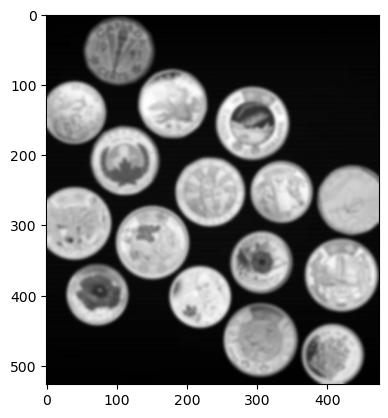

In [2]:
from PIL import Image, ImageFilter 

# read image and convert to grayscale and apply Gaussian filter 
image = Image.open('coin5.jpg').convert('L').filter(ImageFilter.GaussianBlur)

# convert to numpy array
np_image = np.array(image)

# visalize grayscale blurred image
plt.imshow(np_image, cmap='gray')


### Thresholding Image
---

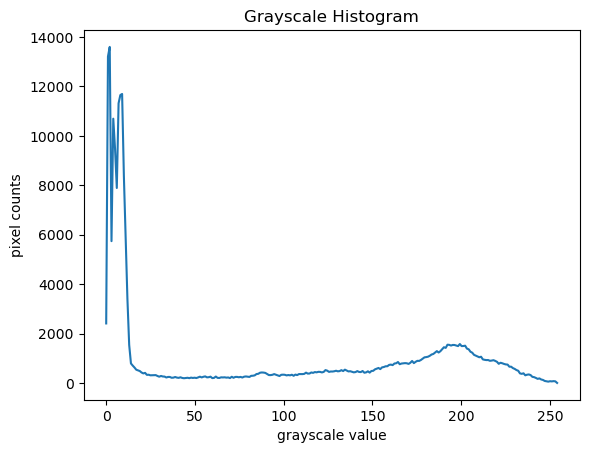

In [3]:
# grayscale images contain pixel values in the range from 0 to 255, 
# so we are looking for a threshold t in the closed range [0.0, 255.0]

# One way to determine a value for t is to look at the grayscale histogram of the image 
# and try to identify what grayscale ranges correspond to the shapes in the image or the background

histogram, bin_edges = np.histogram(np_image, bins=256, range=(0, 255))

# histogram -> representing the number of pixels with the intensity value corresponding to the index

# visualize histogram of grayscale value and pixel counts
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)

plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel counts")
plt.show()

- Since the image has a black background, most of the pixels in the image are black. <br>
This corresponds nicely to what we see in the histogram: there is a peak near the value of 0. 
- If we want to select the shapes and not the background, we want to turn off the black background pixels, while leaving the pixels for the shapes turned on. So, we should choose a value of t somewhere after the large peak and turn pixels above that value on. Let us choose t=40.

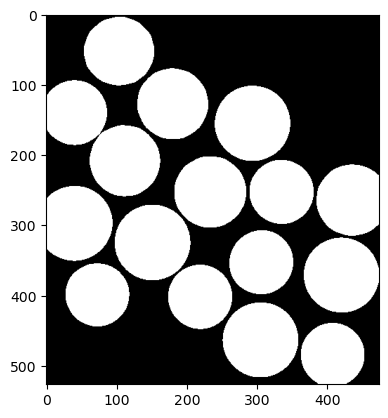

In [4]:
# threshold image
t = 40

binary_image = np.where(np_image > t, 255, 0)

# visualize binary image
plt.imshow(binary_image, cmap='gray')

### Connected Component Labeling Algorithm
---

In [5]:
# get left and above pixel's label
def get_neighbour_label(label, i, j):
        
        left_label = label[i][j - 1]
        above_label = label[i - 1][j]
        
        return left_label, above_label

# two-pass connected-component-labeling algorithm
def label_connected_components(image):
    
    # init labels of image
    label_image = np.zeros(image.shape).astype(int)
    H, W = image.shape
        
    # init label id 
    label_id = 0
    
    # init label equivalency list
    label_eq_list = []
    
    # first pass
    for i in range(H):
        for j in range(W):
            # if foreground pixel
            if image[i][j] == 255:
                
                # get neighbour labels 
                left_label, above_label = get_neighbour_label(label_image, i , j)
                
                # if neither neighbour has labels
                if left_label == 0 and above_label == 0:
                    # assign new label to the pixel
                    label_id += 1
                    label_image[i][j] = label_id
                    
                
                # if one of the neighbour has label or both labels are same 
                elif left_label == 0 or above_label == 0 or left_label == above_label:
                    # assing current pixel to max neighbour label value
                    label_image[i][j] = max(left_label, above_label)
                
                # if both neigbour has different labels 
                else:
                    # assign to min neighbour label value
                    label_image[i][j] = above_label
                    
                    # add labels to label equivalency list
                    label_eq_list.append([above_label, left_label])
    
    # remove duplicate pairs in label equivalency list
    label_eq_list = np.unique(label_eq_list, axis=0)
    
    # init label dictionary
    label_dict = {}
    
    for label_pair in label_eq_list:
        label1, label2 = label_pair
        
        # if the smaller numbered label is in dict 
        if label1 in label_dict:
            # assign larger numbered label to the equivalent label value
            label_dict[label2] = label_dict[label1] 
        
        # assign larger label to smaller label number
        else:
            label_dict[label2] = label1
    
    # second pass, connect equivalent labels
    for i in range(H):
        for j in range(W):
            # get label
            label = label_image[i][j]
            if label in label_dict:
                # assign pixel to the equivalent label
                label_image[i][j] = label_dict[label]
    
    return label_image

def get_largest_connected_component(label_image):
    
    # remove 0 from labels(backgorund label)
    label_mask = label_image[label_image != 0]
    
    # get most frequent label
    label = np.bincount(label_mask.flatten()).argmax()
    
    return label

### Colouring Image
---

The number of objects is:  16


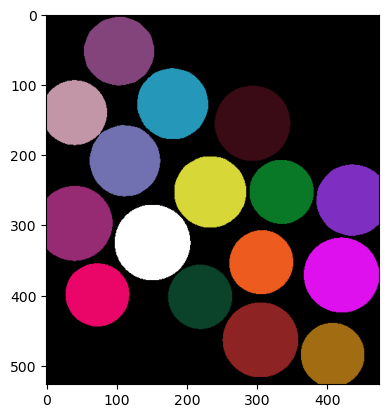

In [27]:
# get labeled connected components  
label_image = label_connected_components(binary_image)

# get most frequent label -> largest object
most_freq_label = get_largest_connected_component(label_image)

# obtain labels
labels = np.unique(label_image)

# discard background label
labels = labels[labels != 0]

# get the number of objects
N = len(labels)

# init colour image
coloured_image = np.zeros((binary_image.shape[0], binary_image.shape[1], 3))

for label in labels:
    # get a random colour
    random_colour =  np.random.choice(range(255), size=3).astype(int)
    
    # colour the object(connected component) in image
    coloured_image[label_image == label] = random_colour

# white colour
white = [255, 255, 255]

# colour the largest object to white
coloured_image[label_image == most_freq_label] = white 


# output the number of objects
print('The number of objects is: ', N)

plt.imshow(coloured_image.astype('uint8'))

### Two Pass Connected Component Labeling Algorithm:

> 1st pass: 

     1: Starting from the initial pixel (0, 0)
     2: Scan the image from top to bottom (y)
        3: Scan the image from left to right (x)
            4: If pixel value (x, y) equals to 255:
            5:
                If both (x, y − 1), (x - 1, y) neighbouring pixels do not have a label:
                    1: Increase the label id 
                    2: Assing the label id to the pixel (x,y)

                If one of the (x − 1, y) or (x, y-1) neighbouring pixel have a label or their labels are same:
                    1: Assign label of the larger numbered label to the (x, y) pixel 

                If both neighbouring pixel have (x − 1, y), (x, y − 1) different labels:
                    1: Assign (x − 1, y) pixel's label to (x, y) pixel
                    2: Record the label equivalency of (x-1, y) ve (x,y-1) pixel's labels to list
    6: end

> 2nd Pass:

     1: Starting from the initial pixel (0, 0)
     2: Scan the image from top to bottom (y)
        3: Scan the image from left to right (x)
            4: If pixel has a label and the label is in the label-equivalency list:
                5: Assign pixel to the smallest numbered label
    6: end
---

### Resources:

https://en.wikipedia.org/wiki/Connected-component_labeling <br>
https://www.youtube.com/watch?v=ticZclUYy88 <br>
https://www.cs.auckland.ac.nz/~georgy/research/texture/thesis-html/node68.html <br>
https://datacarpentry.org/image-processing/07-thresholding/ <br>
https://iq.opengenus.org/connected-component-labeling/ <br>